**Import Necessary Libraries for Image processing, Randomization, and Visualization**


In [1]:
import os
import random
import cv2 as cv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
import nbformat
from PIL import Image


**Mount Google Drive to access Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Set the directory path for the dataset and list all categories in the training directory.**

In [3]:
TRAIN_DIR = '/content/drive/MyDrive/Animals/Animals/Animals'
CATEGORIES = []
for c in os.listdir(TRAIN_DIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['Leopard', 'Jaguar', 'Tiger', 'Cheetah', 'Lion']




**1.**   **Load images from each category**

**2.**   **Resize them to 224x224**

**3.**   **Store them in a list with their corresponding class labels**





In [4]:
import os
import cv2 as cv
from tqdm import tqdm

TRAIN_DATA = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        img_arr = cv.imread(os.path.join(path, img))
        img_arr = cv.resize(img_arr, (224, 224), interpolation=cv.INTER_AREA)  # Resize to 224x224
        TRAIN_DATA.append([img_arr, class_num])

print(len(TRAIN_DATA))


100%|██████████| 32/32 [00:18<00:00,  1.74it/s]

170


**Shuffle the dataset to ensure random distribution**

In [5]:
random.shuffle(TRAIN_DATA)

**Convert the images to grayscale and display the first 50 images**

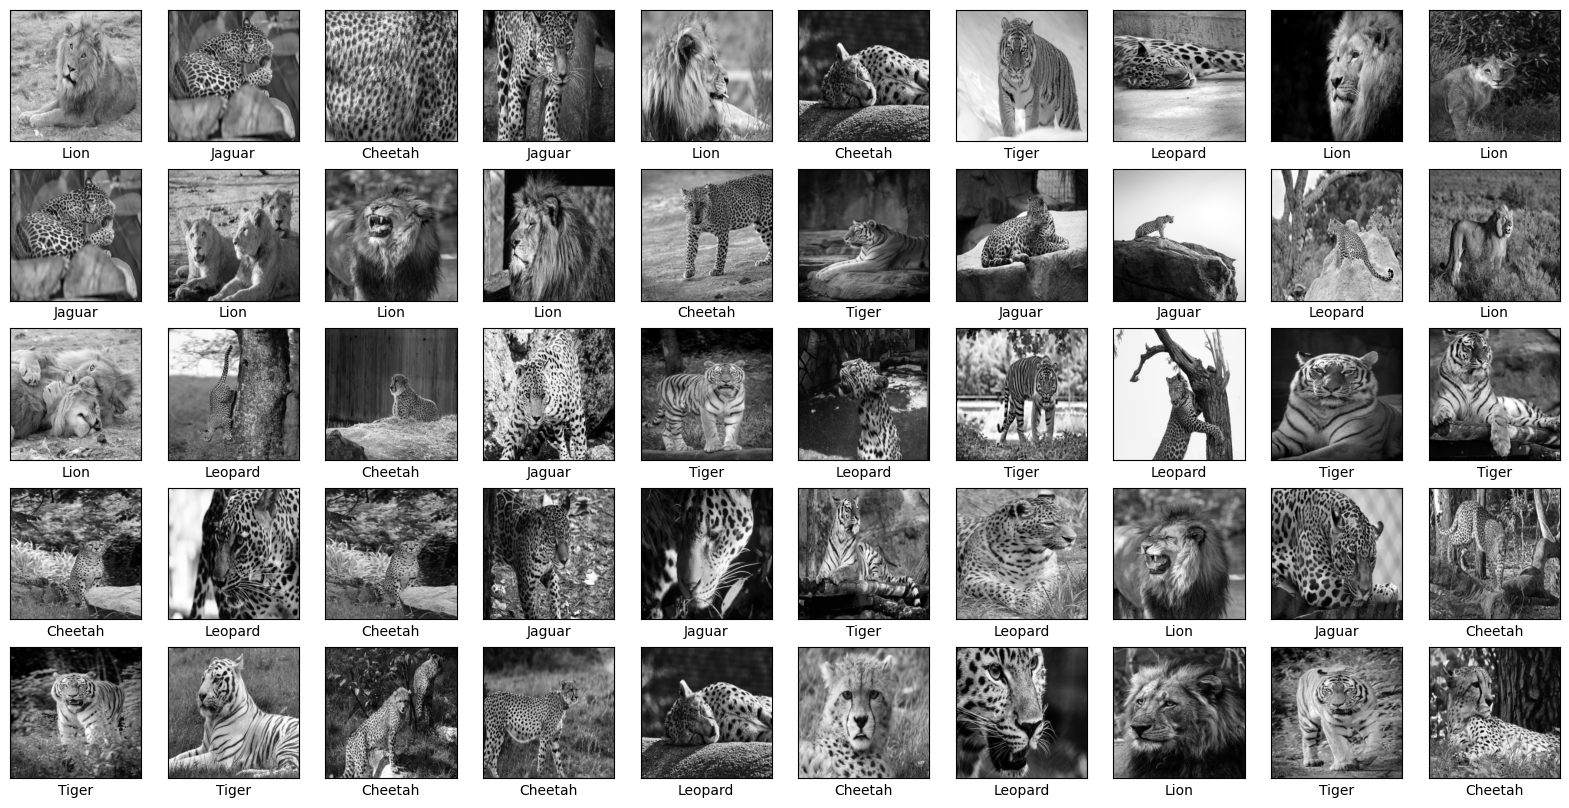

In [6]:
plt.figure(figsize=(20,10))

for i in range(50):
  plt.subplot(5, 10, i+1)
  image = TRAIN_DATA[i][0]
  image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # Convert image to grayscale
  plt.imshow(image_gray, cmap="gray")
  plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
  plt.xticks([])
  plt.yticks([])
  plt.axis()
  if i == 50:
    break
plt.show()

**Manually define 5 splits of approximately equal size and verify the sizes of each split**

In [7]:
# Manually define 5 splits of approximately equal size
f1 = TRAIN_DATA[0:34]
f2 = TRAIN_DATA[34:68]
f3 = TRAIN_DATA[68:102]
f4 = TRAIN_DATA[102:136]
f5 = TRAIN_DATA[136:170]

# Verify the sizes of each split
print(f"f1 size: {len(f1)}")
print(f"f2 size: {len(f2)}")
print(f"f3 size: {len(f3)}")
print(f"f4 size: {len(f4)}")
print(f"f5 size: {len(f5)}")


f1 size: 34
f2 size: 34
f3 size: 34
f4 size: 34
f5 size: 34


**Calculate L2 distances between training and validation sets, keeping the top 20 closest neighbors**

In [8]:
import numpy as np
from tqdm import tqdm

k_range = 30  # K values range from 1 to 30
top_filter = 20  # Number of nearest neighbors to keep

# Function to sort by L2 distance
def by_l2_dist(item):
    return item[2]["l2"]

# Calculate L2 distances between training and validation sets
def distance_calc(train_fold, valid_fold):
    l2_result = []
    for valid in tqdm(valid_fold):  # Iterate through validation set
        temp_dist_list = []
        for train in train_fold:  # Compare with each training sample
            l2_dist = np.sqrt(np.sum((valid[0] - train[0])**2))  # Euclidean distance
            temp_dist_list.append([valid[1], train[1], {"l2": l2_dist}])
        temp_dist_list.sort(key=by_l2_dist)  # Sort neighbors by L2 distance
        l2_result.append(temp_dist_list[:top_filter])  # Keep only top 20 closest
    return [l2_result]


**Define a function to compute accuracy for different K values by classifying based on nearest neighbors and resolving ties with L2 distance**

In [9]:
# Function to calculate accuracy for different values of K
def cal_accuracy(dist_result, dist_term):
    k_accuracies = []
    for k in range(1, k_range + 1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]  # Get K nearest neighbors
            same_class = [n for n in nn if n[0] == n[1]]  # Classify based on majority
            same_class_len = len(same_class)
            if k % 2 != 0:
                if ((k - 1) / 2) < same_class_len:
                    img_accuracy += 1
            else:
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):
                    img_accuracy += 1
                elif same_class_len == len(diff_class):  # tie
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist < diff_class_dist:  # Corrected to prefer smaller L2 distance
                        img_accuracy += 1
        k_accuracies.append(img_accuracy / len(dist_result))
    return k_accuracies


**Perform 5-fold cross-validation by splitting the dataset into training and validation sets, and calculate L2 distances for each fold**

In [10]:
dist_by_fold = []
for i in range(1, 6):
    # Prepare train and validation sets
    if i == 1:
        train = f1 + f2 + f3 + f4
        validation = f5
    elif i == 2:
        train = f1 + f2 + f3 + f5
        validation = f4
    elif i == 3:
        train = f1 + f2 + f4 + f5
        validation = f3
    elif i == 4:
        train = f1 + f3 + f4 + f5
        validation = f2
    elif i == 5:
        train = f2 + f3 + f4 + f5
        validation = f1

    dist_by_fold.append(distance_calc(train, validation))


100%|██████████| 34/34 [00:00<00:00, 59.01it/s]


**Calculate accuracies for each fold and compute the centroid (mean) accuracy for each K value across all folds**

In [11]:
accuracies = []

# Calculate accuracies for each fold
for result in dist_by_fold:
    l2_accuracy = cal_accuracy(result[0], "l2")
    accuracies.append([l2_accuracy])

# Calculate centroid (mean) of accuracies for each K
centroids = []
for k in range(k_range):
    k_accuracies_for_k = [fold[0][k] for fold in accuracies]  # Extract accuracy for each fold
    centroids.append(np.mean(k_accuracies_for_k))  # Mean accuracy for each K


**Display the accuracies for each K across all folds and print the centroid (mean) accuracy for each K value**

In [12]:
# Display the accuracies for each K and the centroid (mean) accuracy
for k in range(k_range):
    fold_accuracies = [fold[0][k] for fold in accuracies]  # Get accuracies for the k-th value across all folds
    print(f"K = {k + 1}:")
    print(f"Accuracies for each fold: {fold_accuracies}")  # Print accuracy for each fold
    print(f"Centroid (Mean) Accuracy: {centroids[k]:.4f}")  # Print centroid (mean) accuracy for the k-th value
    print("-" * 50)


K = 1:
Accuracies for each fold: [0.29411764705882354, 0.23529411764705882, 0.35294117647058826, 0.35294117647058826, 0.23529411764705882]
Centroid (Mean) Accuracy: 0.2941
--------------------------------------------------
K = 2:
Accuracies for each fold: [0.29411764705882354, 0.23529411764705882, 0.3235294117647059, 0.35294117647058826, 0.23529411764705882]
Centroid (Mean) Accuracy: 0.2882
--------------------------------------------------
K = 3:
Accuracies for each fold: [0.17647058823529413, 0.14705882352941177, 0.17647058823529413, 0.17647058823529413, 0.17647058823529413]
Centroid (Mean) Accuracy: 0.1706
--------------------------------------------------
K = 4:
Accuracies for each fold: [0.14705882352941177, 0.11764705882352941, 0.23529411764705882, 0.17647058823529413, 0.17647058823529413]
Centroid (Mean) Accuracy: 0.1706
--------------------------------------------------
K = 5:
Accuracies for each fold: [0.11764705882352941, 0.08823529411764706, 0.08823529411764706, 0.1470588235

**Plot accuracies for each K across folds and display the centroid accuracy trend with error bars**

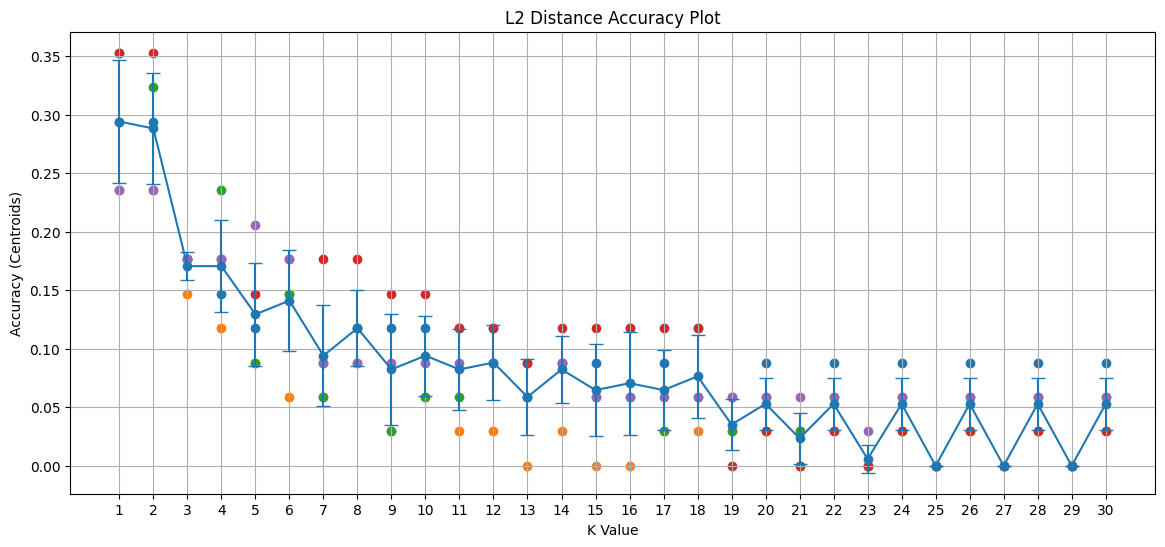

In [13]:
import matplotlib.pyplot as plt
import numpy as np

x_list = list(range(1, k_range + 1))  # K values (1 to 30)

# Plot the accuracies for each fold
plt.figure(figsize=(14, 6))
for fold in accuracies:
    y_list = fold[0]  # fold[0] contains the L2 accuracies
    plt.scatter(x_list, y_list)

# Calculate the standard deviation for each K across all folds
arr = []
for i in range(k_range):
    arr.append([fold[0][i] for fold in accuracies])  # fold[0] contains L2 accuracy for each k

# Calculate the mean accuracy for each K
trend = [np.mean(a) for a in arr]

# Calculate the standard deviation for each K across all folds
std_dev = [np.std(a) for a in arr]  # Standard deviation for each k

# Plot the trend with error bars (standard deviation)
plt.errorbar(x_list, trend, fmt='-o', yerr=std_dev, capsize=5)

plt.title('L2 Distance Accuracy Plot')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K Value')
plt.ylabel('Accuracy (Centroids)')
plt.show()
